## Firm Dynamics - Question 4
### Wei Han Chia

In this question, we combine the dynamic firm problem with a representative agent consumer in order to investigate the equilibrium dynamics of this model.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time
import numba
import pickle

# to print plots inline
%matplotlib inline

### Parametrization
Let us begin with some preliminaries. Firstly, we will calibrate the model in the same way as question 1.

We will use the following parametrization:


| Parameter | Description   | Value|
|------|------||------|
    | $\alpha_{k}$ | Capital's share of output | 0.297 |
   | $\alpha_{l}$ | Labor's share of output | 0.650 |
   | $\delta$ | Depreciation rate | 0.154 |
   | $\psi$ | Coefficient on quadratic adjustment costs | 1.080 |
   | $\sigma_z$   | Std dev of shocks | 0.213 |
   | $\mu$ | Mean of Income Process | 0 |
   | $\rho$ | Persistence of Income Process | 0.7605 |
   | `sizez` | Number of Grid Points of z | 9 |
   | $\beta$ | Household Discount Factor | 0.96 |
   | $h$ | Parameter of disutility of work | 6.6616 |

We can also initialize our grid of productivity shocks. We will leave the grid of capital to be redefined at each iteration.

In [48]:
# Initializing Parameters and Grids

# Parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
mu = 0
rho = 0.7605
sigma_z = 0.213
size_z = 9
beta = 0.96
h = 6.6616
params = alpha_k, alpha_l, delta, psi, beta, h

# Generating grid of transition probabilities and nodes
import ar1_approx as ar1
step = (4 * sigma_z) / (size_z/ 2)
pi, zvec3 = ar1.rouwen(rho, mu, step, size_z)
zvec3 = np.exp(zvec3)

### Firm Equilibrium Equations's

We will define some functions to be used in the iteration of solving the firms problems. This includes generating a new income grid, deriving earnings and labor demand for each (z,k). We denote the solved policy function for some given $\bar{w}_i$ to be $h(z,k;\bar{w}_i)$.

$$ l^d(z,k;\bar{w}_i) = (\frac{\alpha_l}{w})^{\frac{1}{1 - \alpha_l}} z^{\frac{1}{1 - \alpha_l}} k^{\frac{\alpha_k}{1 - \alpha_l}} $$

$$\pi(k,z, \bar{w}_i) =\left(1-\alpha_{l}\right)z^{\frac{1}{1-\alpha_l}} \left(\frac{\alpha_{l}}{\bar{w}_i}\right)^{\frac{\alpha_{l}}{1-\alpha_{l}}}k^{\frac{\alpha_{k}}{1-\alpha_{l}}} $$

$$ e(z,k, h(z,k;\bar{w}_i);\bar{w}_i) = \pi(k,z, \bar{w}_i) - ( h(z,k;\bar{w}_i)-(1-\delta)k) - \frac{\psi}{2}\left(\frac{ h(z,k;\bar{w}_i)-(1-\delta)k}{k}\right)^{2}k $$

$$ I(z,k;\bar{w}_i) = h(z,k;\bar{w}_i) - (1 - \delta)k $$

At equilibrium, we are also interested in finding the aggregate adjustment costs, as well as the aggregate production functions:

$$ y(z,k;\bar{w}_i) = z k^{\alpha_k} (l^d)^{\alpha_l} $$
$$ c(h(z,k;\bar{w}_i) , k) = \frac{\psi}{2} \frac{(h(z,k;\bar{w}_i) - (1 - \delta) k)^2}{k} $$

In [3]:
# Function for creating income grid
def incomegrid(density, kstar):
    dens = density
    # Bouding state space based on steady state capital
    kbar = 2*kstar
    lb_k = 0.001
    ub_k = kbar
    krat = np.log(lb_k / ub_k)
    numb = np.ceil(krat / np.log(1 - delta))
    K = np.zeros(int(numb * dens))
    # we'll create in a way where we pin down the upper bound - since
    # the distance will be small near the lower bound, we'll miss that by little
    for j in range(int(numb * dens)):
        K[j] = ub_k * (1 - delta) ** (j / dens)
    kvec = K[::-1]
    return kvec

def get_kstar(w, params):
    alpha_k, alpha_l, delta, psi, beta, h = params
    return ((((1 / beta - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1 ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))

def get_profit(k,z, w, params):
    alpha_k, alpha_l, delta, psi, beta, h = params
    return ((1 - alpha_l) * ((np.exp(z)) **(1/(1-alpha_l)))* ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
      ((k ** alpha_k) ** (1 / (1 - alpha_l))))

def get_e(kprime, k ,z, w, params):
    alpha_k, alpha_l, delta, psi, beta, h = params
    return profit(k,z,w,params) - (kprime - (1 - delta)*k) - psi/2 * ((kprime - (1 - delta)*k) ** 2 / k)

def get_invest(kprime, k, z, params):
    alpha_k, alpha_l, delta, psi, beta, h = params
    return kprime - (1 - delta)*k

def get_labor_demand(k, z, w, params):
    alpha_k, alpha_l, delta, psi, beta, h = params
    return ((alpha_l / w) ** (1 / 1 - alpha_l)) * ( z ** (1/(1 - alpha_l))) * (k ** ((alpha_k)/(1 - alpha_l)))

def get_y(k,z,w,params):
    alpha_k, alpha_l, delta, psi, beta, h = params
    return z * ( k ** (alpha_k) ) * (get_labor_demand(k,z,w,params) ** (alpha_l)) 

def get_psi(kprime, k, w,z,params):
    alpha_k, alpha_l, delta, psi, beta, h = params
    return (psi/2) * ((kprime - (1 - delta)* k) ** 2)/ k 

### HH FOC's

In equilibrium we also require some household FOC's. In particular, we are interested in the marginal rate of substitution which fixes the wage rate at equilibrium.

$$ \bar{C} \bar{L} h = \bar{w} $$

In [4]:
def get_labor_supply(C, w, params):
    alpha_k, alpha_l, delta, psi, beta, h = params
    return w / (C*h) 

def get_wage(C, L, params):
    alpha_k, alpha_l, delta, psi, beta, h = params
    return C*L*h

### Equilibrium Conditions

The first component of equilibrium which we are interested in is the stationary distribution of firms. Following from the code in the `SolvingStationaryDistributions` notebook, we will solve for the stationary distribution by simulating our economy.

In [17]:
def get_PFindex(PF, kvec):
    # Function to get indices for policy function for stationary distribution simulation
    PFindex = np.empty_like(PF)
    idx = np.zeros_like(kvec)
    for i in range(PF.shape[1]):
        for j in range(kvec.shape[0]):
            idx[j] = np.abs(kvec - PF[j,i]).argmin()
        idx = idx.astype(int)
        PFindex[:,i] = idx
    return PFindex.astype(int)

def get_stationarydist(PF, pi, tol = 1e-12, maxiter = 1000):
    sizek, sizez = np.shape(PF)
    Gamma = np.ones((sizez, sizek)) * (1 / (sizek * sizez))
    SDtol = tol
    SDdist = 7
    SDiter = 0
    SDmaxiter = maxiter
    while SDdist > SDtol and SDmaxiter > SDiter:
        HGamma = np.zeros((sizez, sizek))
        for i in range(sizez):  # z
            for j in range(sizek):  # k
                for m in range(sizez):  # z'
                    HGamma[m, PF[j, i]] = HGamma[m, PF[j, i]] + pi[i, m] * Gamma[i, j]
        SDdist = (np.absolute(HGamma - Gamma)).max()
        Gamma = HGamma
        SDiter += 1
    return Gamma


Given this stationary distribution $\Gamma(z,k;\bar{w}_i)$, we are interested in finding aggregate labor and investment demand, output and adjustment costs. 

$$ \bar{L}^d = \int l^d(z,k;\bar{w}_i) d \Gamma(z,k;\bar{w}_i) $$
$$ \bar{I} = \int l(z,k;\bar{w}_i) d \Gamma(z,k;\bar{w}_i) $$
$$ \bar{\Psi} = \int c(h(z,k;\bar{w}),k) d \Gamma(z,k;\bar{w}_i) $$
$$ \bar{Y} = \int y(z,k,\bar{w}_i) d \Gamma(z,k;\bar{w}_i) $$

With these aggregates, we can then back out aggregate consumption from the aggregate resource constraint

In [24]:
def get_aggY(Gamma, PF, kvec, zvec, w, params):
    aggY = np.zeros_like(Gamma)
    for i in range(kvec.shape[0]):
        for j in range(zvec.shape[0]):
            aggY[j,i] = get_y(kvec[i], zvec[j], w, params)*Gamma[j,i]
    return np.sum(aggY)

def get_aggpsi(Gamma, PF, kvec, zvec, w, params):
    aggpsi = np.zeros_like(Gamma)
    for i in range(kvec.shape[0]):
        for j in range(zvec.shape[0]):
            aggpsi[j,i] = get_psi(kvec[PF[i,j]], kvec[i], w, zvec[j], params)*Gamma[j,i]
    return np.sum(aggpsi)

def get_aggI(Gamma, PF, kvec, zvec, w, params):
    aggI = np.zeros_like(Gamma)
    for i in range(kvec.shape[0]):
        for j in range(zvec.shape[0]):
            aggI[j,i] = get_invest(kvec[PF[i,j]], kvec[i], zvec[j], params)*Gamma[j,i]
    return np.sum(aggI)

def get_agg_labordemand(Gamma, PF, kvec, zvec, w, params):
    aggLD = np.zeros_like(Gamma)
    for i in range(kvec.shape[0]):
        for j in range(zvec.shape[0]):
            aggLD[j,i] = get_labor_demand(kvec[i], zvec[j], w, params)*Gamma[j,i]
    return np.sum(aggLD)

Finally, we also need to import a script to solve for the firm problem endogenously.

### Solving for General Equilibrium
We will solve for the general equilibirum by iteration on $\bar{w}_i$. 

1. First, we note  that at equilibrium we can define $\bar{r} = \frac{1}{\beta} - 1$, which also implies that our firm discount rate is the same as the household discount rate.
2. With these parameters and a guess for $\bar{w}_i$, we can solve the firms problem using the EGP method.
3. With this solution, we can simulate for the steady state, and back out aggregate consumption, as well as labor demand.
4. Using the Household FOC, we can solve for labor supply given aggregate consumption. We can also back out the implied $\bar{w}_i$ from the firm's labor demand from the household FOC. 
5. Given these aggregates, we compare the difference between Labor Supplied and Labor Demanded, and iterate until the error is below our tolerance.
6. We can also update our wage using some economic intuition. Starting from our initial guess, we move in some percentage to the left or the right depending on the relative magnitude of the labor demanded and labor supplied.

This will solution method will provide us with a model of general equilibrium.

In [80]:
%run egpfirmquadcost.py

def solveGE(params, pi, zvec, tol=1e-06, maxiter=1000, density = 1):
    '''Function to solve for General Equilibrium
    params = parameters exogenously determined
    pi = transition proabilities
    zvec = states
    tol = tolerance
    maxiter = maximum iterations
    density = density of capital grid
    
    Returns: wage, interest rate, stationary distribution of capital'''
    alpha_k, alpha_l, delta, psi, beta, h = params
    #Initialize guess for w
    w = 1
    r = 1/beta -1
    errorw = 1
    geiter= 0
    while errorw > tol and geiter < maxiter:
        #Generate k grid
        kstar = get_kstar(w, params)
        kvec = incomegrid(density, kstar)
        #Solving Firm problem given r and w
        PF = egpsolve(kvec, zvec, pi, w, r, params)
        #Simulating stationary distribution
        PF = get_PFindex(PF, kvec)
        Gamma = get_stationarydist(PF, pi)
        #Solving Aggregates
        Cbar = get_aggY(Gamma, PF, kvec, zvec, w, params) - get_aggI(Gamma, PF, kvec, zvec, w, params) - get_aggpsi(Gamma, PF, kvec, zvec, w, params)
        #Get Labor Demand
        Ld = get_agg_labordemand(Gamma, PF, kvec, zvec, w, params)
        #Get Labor Supply
        Ls = get_labor_supply(Cbar, w, params)
        #Get implied wages
        tw = get_wage(Cbar, (Ld + Ls)/2, params)
        #Update Wages
        step = abs(w - tw)/10
        if Ld > Ls:
            w = w + step
        else:
            w = w - step
        #Update error
        errorw = abs(Ls - Ld)
        geiter += 1
        print("Iteration: " + str(geiter) + " Error: " + str(errorw))
        
    return w, r, kvec, Gamma

In [81]:
w, r, kvec, Gamma = solveGE(params, pi, zvec3)
print("Equilibrium Wage = " + str(w) + " Equilibrium interest rate = " + str(r))

Iteration: 1 Error: 0.0180591852336
Iteration: 2 Error: 0.00171125553609
Iteration: 3 Error: 0.000208378017647
Iteration: 4 Error: 2.48190397413e-05
Iteration: 5 Error: 2.96411082418e-06
Iteration: 6 Error: 3.53886412507e-07
Equilibrium Wage = 0.99791107515 Equilibrium interest rate = 0.04166666666666674


As can be seen, our model yields a wage rate 0.997 of and an interest rate of 0.0417. We can also plot the distribution of capital in the steady state.

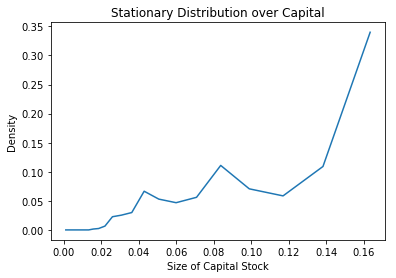

In [83]:
# Plot the stationary distribution over k
fig, ax = plt.subplots()
ax.plot(kvec, Gamma.sum(axis=0))
plt.xlabel('Size of Capital Stock')
plt.ylabel('Density')
plt.title('Stationary Distribution over Capital')
plt.show()